In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# load the metadata
metadata_path = Path.cwd().parent / "data" / "csv" / "meta_data.csv"
output_path = Path.cwd().parent / "graphics" / "eda"
output_path.mkdir(parents=True, exist_ok=True)
df = pd.read_csv(metadata_path)

# Brain Tumor Segmentation - Exploratory Data Analysis

## Introduction

**Dataset:** [**"Brain Tumor Segmentation (BraTS2020)"**]
- **Source**: [[Link](https://www.kaggle.com/datasets/awsaf49/brats2020-training-data?select=BraTS20+Training+Metadata.csv)]
- **Goal**: Understand the dataset before building a deep learning model for automated brain tumor segmentation in MRI scans.

#### What This Notebook Does: ####
1. Explore the Data Structure: 57,000+ MRI slices from 369 brain tumor patients

2. Analyze Tumor Characteristics: Size, location, and composition of tumors

3. Check Data Quality: Ensure images are valid and properly labeled

4. Visualize Samples: See what normal vs tumor MRI slices look like

5. Plan Model Strategy: Based on data insights, decide how to build the segmentation model

#### Key Questions to Answer: ####
1. How many tumor vs non-tumor slices do we have?

2. What's the distribution of tumor sizes?

3. How are tumors distributed across different brain regions (slices)?

4. What preprocessing will our model need?

#### Dataset Structure: ####
- .h5 files: Contain 4 MRI channels (FLAIR, T1, T1ce, T2) + tumor mask
- Metadata CSV: Tells us which slices have tumors, tumor sizes, patient info
- Clicical CSV: Patient survival data and demographics for advanced analysis




### 1. Class Distribution Analysis

**Tumor vs Non-tumor Slice Counts**
- We begin by examining the fundamental class balance between slices containing tumors and those without.
    - This analysis reveals whether our dataset is balanced at the slice level, which shapes our training strategy.
    - Severe imbalance might require weighted loss functions or strategic sampling.

We'll calculate the percentage of tumor-positive slices and visualize the distribution.


Class Distribution Analysis

Dataset Statistics:
   Total MRI slices: 57,195
   Tumor slices: 24,422 (42.7%)
   Healthy slices: 32,773 (57.3%)
   Balance ratio (healthy:tumor): 1.3:1


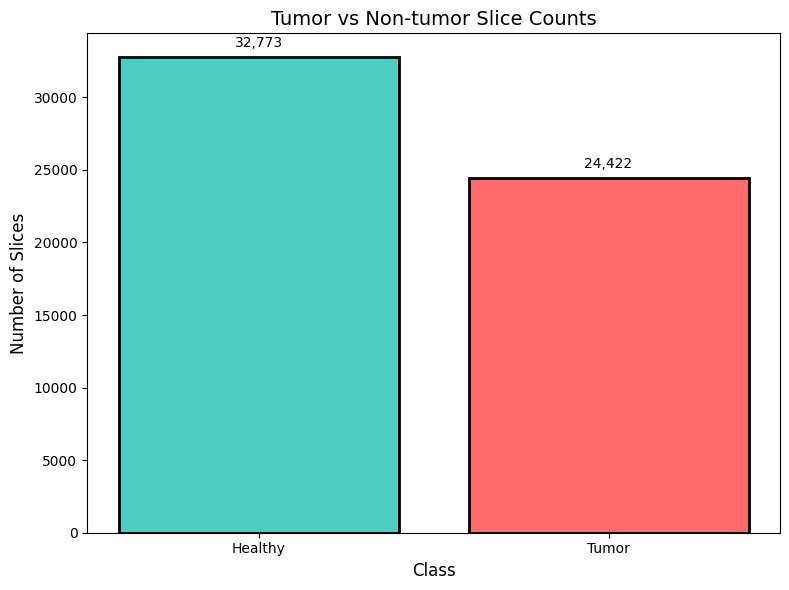


Patient-Level Analysis:
   Total patients: 369
   Patients with tumors: 369 (100.0%)
   Patients without tumors: 0

Slices per Patient:
   Average slices per patient: 155.0
   Min slices: 155
   Max slices: 155
   Std deviation: 0.0


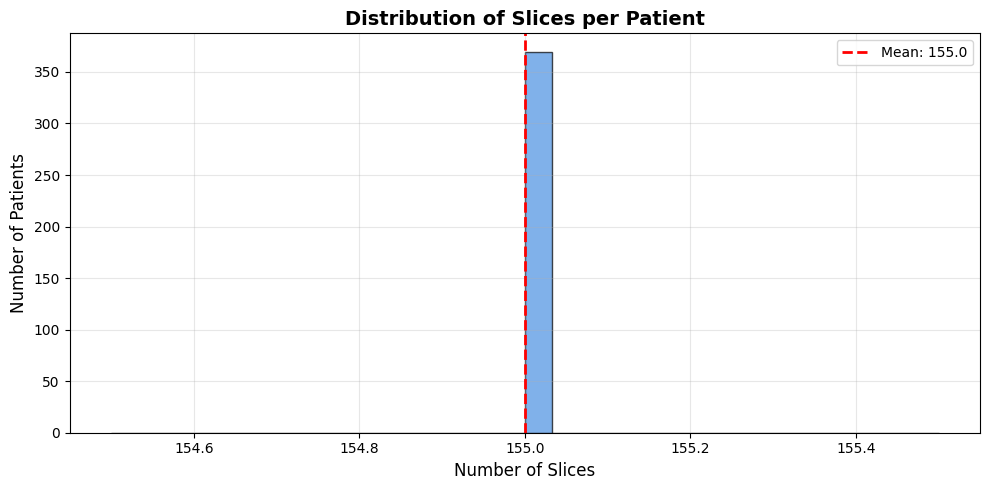

Tumor slices ≥ 40% of dataset

Analysis complete. Results saved.


In [14]:
# create output directory
output_dir = Path(output_path)
output_dir.mkdir(parents=True, exist_ok=True)

print("Class Distribution Analysis")

# calculate basic statistics
total_slices = len(df)
tumor_slices = df['target'].sum()
healthy_slices = total_slices - tumor_slices

# calculate percentages
tumor_percentage = (tumor_slices / total_slices) * 100
healthy_percentage = (healthy_slices / total_slices) * 100

print(f"\nDataset Statistics:")
print(f"   Total MRI slices: {total_slices:,}")
print(f"   Tumor slices: {tumor_slices:,} ({tumor_percentage:.1f}%)")
print(f"   Healthy slices: {healthy_slices:,} ({healthy_percentage:.1f}%)")
print(f"   Balance ratio (healthy:tumor): {healthy_slices/tumor_slices:.1f}:1")

# create visualization - single plot (no pie chart)
fig, ax = plt.subplots(figsize=(8, 6))

# bar plot
class_counts = [healthy_slices, tumor_slices]
class_labels = ['Healthy', 'Tumor']
colors = ['#4ECDC4', '#FF6B6B']

ax.bar(class_labels, class_counts, color=colors, edgecolor='black', linewidth=2)
ax.set_title('Tumor vs Non-tumor Slice Counts', fontsize=14)
ax.set_ylabel('Number of Slices', fontsize=12)
ax.set_xlabel('Class', fontsize=12)

# add value labels on bars
for i, count in enumerate(class_counts):
    ax.text(i, count + 500, f'{count:,}', ha='center', va='bottom')

plt.tight_layout()
# save to the output path
output_file = output_dir / "class_distribution.png"
plt.savefig(output_file, dpi=250, bbox_inches='tight')
plt.show()

# distribution across patients
print("\nPatient-Level Analysis:")

# count patients with/without tumors
patients_with_tumors = df[df['target'] == 1]['volume'].nunique()
patients_total = df['volume'].nunique()
patients_tumor_percentage = (patients_with_tumors / patients_total) * 100

print(f"   Total patients: {patients_total}")
print(f"   Patients with tumors: {patients_with_tumors} ({patients_tumor_percentage:.1f}%)")
print(f"   Patients without tumors: {patients_total - patients_with_tumors}")

# slices per patient distribution
slices_per_patient = df.groupby('volume').size()
print(f"\nSlices per Patient:")
print(f"   Average slices per patient: {slices_per_patient.mean():.1f}")
print(f"   Min slices: {slices_per_patient.min()}")
print(f"   Max slices: {slices_per_patient.max()}")
print(f"   Std deviation: {slices_per_patient.std():.1f}")

# visualize slices per patient
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(slices_per_patient, bins=30, color='#4A90E2', edgecolor='black', alpha=0.7)
ax.axvline(slices_per_patient.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {slices_per_patient.mean():.1f}')
ax.set_title('Distribution of Slices per Patient', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Slices', fontsize=12)
ax.set_ylabel('Number of Patients', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
# save to the output path
output_file = output_dir / "slices_per_patient.png"
plt.savefig(output_file, dpi=250, bbox_inches='tight')
plt.show()

# class imbalance assessment
if tumor_percentage < 30:
    print("\nTumor slices < 30% of dataset")
elif tumor_percentage < 40:
    print("\nTumor slices 30-40% of dataset")
else:
    print("Tumor slices ≥ 40% of dataset")

# save summary statistics
summary_stats = {
    'total_slices': total_slices,
    'tumor_slices': tumor_slices,
    'healthy_slices': healthy_slices,
    'tumor_percentage': tumor_percentage,
    'healthy_percentage': healthy_percentage,
    'total_patients': patients_total,
    'patients_with_tumors': patients_with_tumors,
    'avg_slices_per_patient': slices_per_patient.mean()
}

summary_df = pd.DataFrame([summary_stats])
# save to directory
summary_df.to_csv(output_dir / 'summary_class_distribution.csv', index=False)

print("\nAnalysis complete. Results saved.")


**We found that:**
- No severe class imbalancing required; moderate balance achieved
    - 43% tumor vs 57% healthy slices
- All patients have tumors
    - "Healthy" slices are tumor-free regions within glioma patients, not scans from healthy individuals.
- All 369 patients have exactly 155 slices at 240x240 resolution with 4 MRI modalities.


### 2. Tumor Size & Characteristics

**Tumor Pixel Count Distribution**
- Before feeding into the model, we want to get an understanding of the distribution of tumor sizes in our dataset. 
    - Small tumors are hard to spot, big ones are easier but complicated.

We will make a histogram to see the spread.


### 3. Spatial Analysis 

**Tumor Occurrence by Slice Position**
- The brain has 155 slices from top to bottom; we want to know if tumors appear everywhere or only in certain spots?
    - Analyzing the distribution of tumors across these slices tells us if we can ignore certain slices.

We will make a grpaih showing tumor frequency per slice.

### 4. Patient-Level Analysis

**Distribution of Slices Per Patient**
- It is important that all patients have a similar number of slices for consistent analysis and are not missing slices.
- We must also split by patient not by slice to avoid data leakage.


### 5. Sample Visualization 
**Sample Cases with Different Tumor Sizes**
- Show 3 examples: a tiny tumor (hard case), medium tumor (typical case), huge tumor (easy but complex). 
- Include the 4 MRI types and the colored tumor mask overlay. This shows what we're actually trying to predict.

## Conclusion